In [1]:
from flo_ai import Flo
from flo_ai import FloSession
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# load the document and split it into chunks
loader = TextLoader("./rag_document.txt")
documents = loader.load()

# split it into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# load it into Chroma
db = Chroma.from_documents(docs, embedding_function)

/Users/vizsatiz/Documents/hub/flo/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/vizsatiz/Documents/hub/flo/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from flo_ai.retrievers.flo_retriever import FloRagBuilder
from flo_ai.retrievers.flo_compression_pipeline import FloCompressionPipeline

llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini')
session = FloSession(llm)
builder = FloRagBuilder(session, db.as_retriever())
compression_pipeline = FloCompressionPipeline(OpenAIEmbeddings(model="text-embedding-3-small"))
compression_pipeline.add_embedding_reduntant_filter()
compression_pipeline.add_embedding_relevant_filter()
# Reranking

retriever_tool = builder.with_compression(compression_pipeline).build_retriever_tool(name="HousingLoanRetreiver",
                                                                                               description="Tool to fetch data around housing loans")
session.register_tool(name="HousingLoanTool", tool=retriever_tool)

2024-09-22 16:42:53,250 - SESSION - INFO - New FloSession created with ID: f931f117-6901-49b2-a69e-5d9c48416320
2024-09-22 16:42:53,336 - SESSION - INFO - Tool 'HousingLoanTool' registered for session f931f117-6901-49b2-a69e-5d9c48416320


2024-09-22 16:52:46,167 - BUILDER - INFO - Building Flo instance from YAML
2024-09-22 16:52:46,177 - COMMON - INFO - Flo instance created for session f931f117-6901-49b2-a69e-5d9c48416320


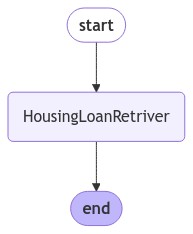

In [10]:
agent_yaml = """
apiVersion: flo/alpha-v1
kind: FloRoutedTeam
name: agentic-rag
team:
    name: AgenticRAGTeam
    router:
        name: SupportSupervisor
        kind: linear
    agents:
      - name: HousingLoanRetriver
        job: Fetching the loan information from the loan tool
        tools:
          - name: HousingLoanTool
"""

flo = Flo.build(session, agent_yaml)

flo.draw()

In [11]:
print(flo.invoke("Whats the interest rate for housing loan ?"))

2024-09-22 16:52:49,141 - COMMON - INFO - Invoking query for session f931f117-6901-49b2-a69e-5d9c48416320: Whats the interest rate for housing loan ?
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)




> Entering new AgentExecutor chain...

Invoking: `HousingLoanRetreiver` with `{'query': 'interest rate for housing loan'}`


You can use any one of the ways to repay the loan:
 
  Cheques
  Standing instructions at your branch
  FedNet - Internet Banking
  Automated Payment through ECS
  Mobile Banking

  Housing loan interest rates will change subject to the changes made by Bank/RBI from time to time. 

Present Repo Rate	 6.50%  (p.a)
 

Loan scheme

Interest Rate (%) * 

Home Loan  

8.80 (Repo Rate+ 2.30) Onwards 

*T&C Apply

Housing Loan

Your dream home is never far away! Get hassle free home loans from Federal Bank to turn your dream home into reality. We assist you to realize your dream home. Avail your Housing Loan from us at competitive interest rates. The loan scheme assists borrowers for construction of house, acquisition of land & construction of house, repairs / renovation / remodeling / extension of house, reimbursement of debt incurred for construction / purchase / fu